<a href="https://colab.research.google.com/github/Fahim-Anin/Machine_Learning_Internship/blob/main/Real_Time_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile


#  path to the ZIP file
zip_file_path = "/content/drive/MyDrive/mask_images_ready.zip"
destination_folder = "/content/drive/MyDrive/Colab Notebooks/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


print("Folder extraction completed.")

Folder extraction completed.


In [3]:
# Import necessary packages and libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [4]:
# changing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#  FaceMaskDataset class for training, validation, and test data
class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# FaceMaskDetector class
class FaceMaskDetector:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model(model_path).to(self.device)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_model(self, model_path):
        model = models.resnet50(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 2)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model

    def detect(self, frame):
        frame = self.transform(frame).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(frame)
        probabilities = torch.softmax(output, dim=1)[0]
        mask_probability = probabilities[1].item()
        no_mask_probability = probabilities[0].item()
        label = "Mask" if mask_probability > no_mask_probability else "No Mask"
        return label

In [7]:
# The training parameters
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/train"
val_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/val"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/test"
model_save_path = "/content/drive/MyDrive/Final_FaceMask_detection_model.pt"
batch_size = 16
num_epochs = 12

In [8]:
# Load the training data
train_image_paths = []
train_labels = []

for folder_name in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                train_image_paths.append(file_path)
                train_labels.append(1 if folder_name == "1" else 0)

In [9]:
# Load the validation data
val_image_paths = []
val_labels = []

for folder_name in os.listdir(val_data_dir):
    folder_path = os.path.join(val_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                val_image_paths.append(file_path)
                val_labels.append(1 if folder_name == "1" else 0)

In [10]:
# Load the test data
test_image_paths = []
test_labels = []

for folder_name in os.listdir(test_data_dir):
    folder_path = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                test_image_paths.append(file_path)
                test_labels.append(1 if folder_name == "1" else 0)

In [11]:
# FaceMaskDataset class for training, validation, and test data
train_dataset = FaceMaskDataset(train_image_paths, train_labels, transform=transforms.ToTensor())
val_dataset = FaceMaskDataset(val_image_paths, val_labels, transform=transforms.ToTensor())
test_dataset = FaceMaskDataset(test_image_paths, test_labels, transform=transforms.ToTensor())

In [12]:
#  training, validation, and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Function to show a batch of images during training
import matplotlib.pyplot as plt

def show_batch(images, labels):
    fig, axes = plt.subplots(figsize=(12, 6), ncols=4)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title("With Mask" if labels[i] == 1 else "Without Mask")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [14]:
# FaceMaskModel class
class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.model(x)



# FaceMaskModel class
model = FaceMaskModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


In [15]:
# the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Move the model to the device
model = model.to(device)

Epoch 1/12
Train Loss: 0.1726 | Train Accuracy: 86.11%
Val Loss: 0.7077 | Val Accuracy: 92.86%
-------------------------------
Epoch 2/12
Train Loss: 0.0162 | Train Accuracy: 98.61%
Val Loss: 7.5174 | Val Accuracy: 78.57%
-------------------------------
Epoch 3/12
Train Loss: 0.0122 | Train Accuracy: 100.00%
Val Loss: 0.0000 | Val Accuracy: 100.00%
-------------------------------
Epoch 4/12
Train Loss: 0.0285 | Train Accuracy: 98.61%
Val Loss: 6.3775 | Val Accuracy: 50.00%
-------------------------------
Epoch 5/12
Train Loss: 0.0665 | Train Accuracy: 98.61%
Val Loss: 0.5501 | Val Accuracy: 85.71%
-------------------------------
Epoch 6/12
Train Loss: 0.0009 | Train Accuracy: 100.00%
Val Loss: 0.4098 | Val Accuracy: 85.71%
-------------------------------
Epoch 7/12
Train Loss: 0.0021 | Train Accuracy: 100.00%
Val Loss: 0.1851 | Val Accuracy: 92.86%
-------------------------------
Epoch 8/12
Train Loss: 0.2243 | Train Accuracy: 93.06%
Val Loss: 25.5175 | Val Accuracy: 50.00%
-----------

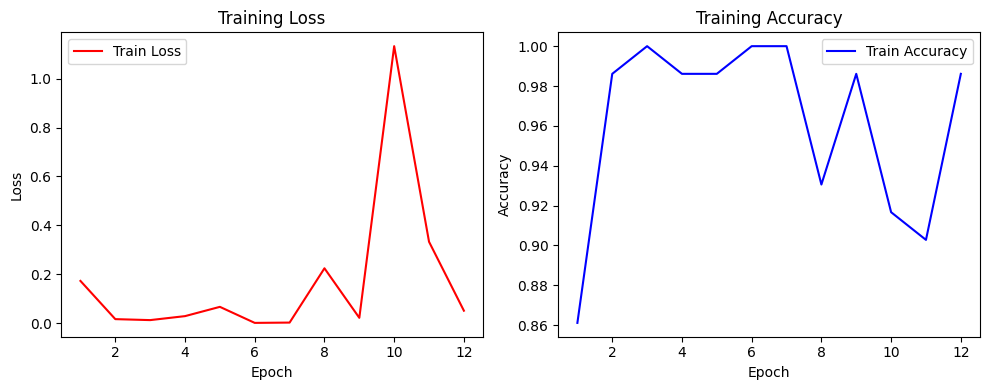

In [16]:
# list to save the train loss and accuracy for plotting
train_loss_values = []
train_accuracy_values = []



# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()


    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    train_loss_values.append(train_loss)  # Append train loss value to the list
    train_accuracy_values.append(train_accuracy)  # Append train accuracy value to the list

    # Model evaluation on the validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_accuracy = val_correct / val_total
    val_loss = val_loss / len(val_loader)


    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.2f}%")
    print("-------------------------------")


#Plotting train loss and accuracy

# list of epoch numbers
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))


# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
# plt.show()

# Plot train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy', color="blue")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
# plt.show()


plt.tight_layout()
plt.show()

In [17]:
# Save the trained model
torch.save(model.state_dict(), model_save_path)

# Model evaluation on test data
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = test_correct / test_total
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")



# save the model one more time after checking good accuracy
torch.save(model.state_dict(), model_save_path)

Test Loss: 23.1151 | Test Accuracy: 50.00%


In [18]:
from google.colab import files

model_path = model_save_path

files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from google.colab import files



class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.model(x)



# calling our model
model = FaceMaskModel()




# the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



uploaded = files.upload()



# Getting the uploaded image file
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)



# Preprocess the image
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension




# face mask detection
with torch.no_grad():
    model.eval()
    output = model(input_batch)




class_probabilities = torch.softmax(output, dim=1)
mask_probability = class_probabilities[0, 1].item()


threshold = 0.5  #treshold
if mask_probability > threshold:
    print("Face mask detected with probability:", mask_probability)
else:
    print("No face mask detected with probability:",1- mask_probability)

Saving 1.jpg to 1.jpg
Face mask detected with probability: 0.5856109261512756
